# Automatic Creating of Mining Polygons using Herarchical Clustering Techniques

Hierarchical Clustering es una técnica de agrupación de bloques en clusters de acuerdo a medidas de similaridad y disimilaridad. Existen 2 enfoques:

* *Agglomerative Clustering*: Consiste en partir con los clusters a nivel de bloques, e ir agrupando de acuerdo a un criterio de similaridad. Si no hay un criterio de parada, termina cuando cuando todos los bloques se agrupan en 1 cluster.
* *Divisive Clustering*: Consiste en partir con un cluster, e ir dividiendo en 2 de acuerdo a un criterio de disimilaridad. Si no hay un criterio de parada, termina cuando todos los cluster son 1 bloque.

## Índices de similitud

Existen varias medidas de similitud, pero todas comparten algunas reglas básicas (definición de índice de similitud):

* El índice de similitud es un cociente entre medidas de similitud/disimilitud
\begin{equation*}
    \text{I. Similitud} = \frac{\text{Medida Similitud}}{\text{Medida Disimilitud}}
\end{equation*}
Donde las medidas de similitud y disimilitud dependen de ciertos factores, como tipo de roca o distancia, respectivamente.

* Todos los factores de que determinan la similitud o disimilitud están normalizadas.

* Se usa un valor de pensalización (entre 0 y 1) para los factores categóricos (eg. Tipo de roca, Destino, Periodo de extracción) y una distancia de Minkwski (p-norm) para valores numéricos (eg. Distancia, Ley) y se divide por el mayor valor entre todos estos (para normalizar).

## Algoritmo
El pseudocódigo del clustering tendría la siguiente forma:
 ```mermaid
FOR EACH bench IN dataset 
    SimilarityMatrix = Calculate_Similarity_Matrix()
    AdjencyMatrix = Create_Adjency_Matrix()
    NumerOfClusters = NumberOfBlocks
    MaxNumberOfClusters = NumberOfBlocks/AverageDesiredNumberOfBlocksInCluster \\ Opcional

    WHILE NumberOfClusters > MaxNumberOfClusters
        (i,j) = Find_Most_Similar_Adjacent_Clusters(AdjencyMatrix, SimilarityMatrix)
        IF length(Clusters(i)) + length(Clusters(j)) <= MaxClusterLength THEN
            SimilarityMatrix(i,:) = Min(SimilrityMatrix(i,:), SimilarityMatrix(j,:))
            SimilarityMatrix(j,:) = 0
            AdjancencyMatrix(i,:) = Max(AdjancencyMatrix(i,:), AdjancencyMatrix(j,:))
            AdjancencyMatrix(j,:) = 0
            Clusters(i) = Clusters(i) + Clusters(j)
            NumberOfClusters = NumberOfClusters - 1
        ELSE
            AdjacencyMatrix(i,j) = 0
        ENDIF
    ENDWHILE

    SmallClusters = Get_Small_Clusters(Clusters, MinClustersSize)
    Clusters = Explode_Clusters(SmallClusters)

    FOR NumberOfIterations \\(Mientras hayan corner blocks)
        CornerBlocks = Find_Corner_Blocks()
        Modify_Cluster_IDs(CornerBlocks)
        Clusters = Remove_Empty_Clusters(Clusters)
    ENDFOR
ENDFOR
```

Note que cada vez que agrupamos clusters, es necesario actualizar los índices de similaridad. Hay 3 enfoques para calcular la similaridad entre clusters:
* Single Link
* Complete Link
* Average Link

Tabesh y Askari-Nasab, después de probar todos los enfoques, escogió Complete Link, en el cual la similaridad entre dos clusters está determinada por la similaridad mínima entre todos los pares de bloques entre los dos clusters.

## Comentarios de Tabesh y Askari-Nasab de la implementación
Utilizaron 3 casos de estudio para verificar el rendimiento del algoritmo en distintas situaciones
* Mina de oro de 90.000 bloques de 50x50x15 [pies]. Ésta data se usó para comentar acerca del tiempo de procesamiento y recursos necesarios para correr el algoritmo en un modelo de tamaño real. Hay 4 tipos de material: oro, plata, cobre y sulfuro. Los minerales de oro y plata con alta ley son llevados a un molino, mientras que los de oro de baja ley y de cobre de alta ley son llevados a una planta de lixivización.
* El segundo dataset es una pequeña región de la misma mina, de 874 bloques, usada para ilustrar las características del modelo.
* El tercer dataset es una pequeña región de una "oil sands operation" para ilustrar otra implementación de la técnica de clustering. Consiste en 2792 bloques categorizados en 5 materiales distintos.

Se definen 4 medidas de calidad del clustering, definidas en base a los objetivos para los cuales se formaron los clusters.
* La primera medida es de acuerdo al tamaño del cluster. El objetivo es obtener un tamaño acotado y adecuado, pues clusters demasiado grandes o demasiado pequeños no son convenientes para la planificación minera.
* Las otras 3 medidas son respecto a la homogeneidad del tipo de roca, destino de cada bloque y la ley de cada elemento, llamadas rock unity, destination dilution factor, and grade variation in clusters.

**Rock Unity** (RU) se define como la porción más grande del tipo de roca del cluster.

**Destination Dilution Factor** (DDF) es el tonelaje de los bloques que comparten destino dividido entre el total de tonelaje del cluster.

**Coefficient of Variation** (CV) es un parámetro conocido que es calculado dividiendo la desviación estándar de los valores respecto a su media (de la ley de cada bloque). El promedio del CV del mayor elemento de la mina es otra medida de rendimiento que representa la homogeneidad de la ley en los clusters.


### Control del tamaño de los clusters
El clustering se realiza de "abajo hacia arriba" en términos de tamaño, por lo que el tamaño del cluster se puede controlar relativamente fácil. El tamaño de un nuevo cluster se verifica vs el tamaño máximo cada vez que dos clusters son escogidos para ser unidos. Si se viola esta condición, simplemente los clusters no se unen.

Otro mecanismo de control del tamaño es calcular el número total de clusters dividiendo el número total de bloques entre la media de bloques en caad cluster, y terminar el procedimiento de clustering cuando el número de clusters es igual al número deseado de clusters.

También se puede aplicar un criterio de tamaño mínimo de cluster en el postprocesado, de modo de remover los clusters que quedaron de un tamaño menor a cierto umbral (Barca, Rumantir). La implementación de este criterio puede hacer que algún cluster viole el tamaño máximo, al ser un postprocesado.

[Ver qué sucede cuando sólo un bloque es un cluster y sólo tiene 1 vecino de otro clúster]

### Postprocesado
Se implementa una etapa de postprocesado para refinar la forma de los clusters. Se encarga de dos cambios:
* Remover puntas (sharp corners)
* Remover clusters pequeños

El proceso consiste en que, los clusters de tamaño muy pequeño son desagregados en clusters de 1 solo bloque, y se comienza con el refinamiento de formas. Este es un proceso iterativo en el que los bloques que cumplen que tienen menos (o igual) de un bloque adjacente del mismo cluster y más (estricto) de un bloque adjacente de otro cluster, son desprendidos del cluster original y añadidos a aquel con más vecinos. Este proceso se repite hasta que no hayan más bloques corner.


#### Clustering usando sólo distancia como medida de disimilitud
El índice de similaridad, cuando sólo consideramos la distancia como medida de disimilitud se calcula por
\begin{equation*}
    S_{ij} = \frac{1}{\tilde{D}_{ij}}
\end{equation*}

donde $\tilde{D}_{ij}$ es la distancia normalizada entre los bloques $i$ y $j$. De la misma forma puede ser definida una medida de similaridad de acuerdo a sólo la ley de los bloques.

En general, clusterizar de acuerdo a sólo una de estas medidas no es del todo útil considerando el cómo se procesan los clústers en planta.

### Clustering con más medidas de similitud
El índice de similaridad se calcula como
\begin{equation*}
    S_{ij} = \frac{T_{ij}}{\tilde{D}_{ij}^{W_D} \cdot \tilde{G}_{ij}^{W_G}}
\end{equation*}
donde $T_{ij}$ es la penalización aplicada si los bloques $i$ y $j$ no son enviados al mismo destino y $\tilde{G}_{ij}^{W_D}$ es la diferencia normalizada entre las leyes de los bloques $i$ y $j$.

### Directional Mining Units
La clusterización también se puede usar para crear planes de corto plazo de unidades de minería, control y explosión de mineral. Por ello, la forma de los clusters debiese ser consistente con la dirección de minería.

Por ello, también podemos tomar una medida de similaridad de acuerdo con la dirección de minería, tomando en cuenta la distancia de cada bloque de la recta de la dirección de minería, determinado por dos puntos en el plano coordenado ajustados por el usuario como punto inicial y final de minería. Esto puede resultar en clusters perpendiculares a la dirección de minería. El índice de similitud respecto a la dirección de minería es el siguiente

\begin{equation*}
    S_{ij} = \frac{T_{ij}}{\tilde{D}_{ij}^{W_D} \cdot \tilde{G}_{ij}^{W_G} \cdot \tilde{M}_{ij}^{W_M}}
\end{equation*}

donde 
\begin{equation*}
    M_{i} = \text{sign}\left( (M_i^1)^2 - (M_i^2)^2 \right)\sqrt{\left| (M_i^1)^2 - (M_i^2)^2 \right|}
\end{equation*}
$M_i^1$ y $M_i^2$ es la distancia euclideana al punto de inicio y término de la dirección de minería, respectivamente.

Es poco recomendable usar todos los parámetros de similitud, pues sus efectos se pueden contrarrestar. Por ejemplo, se puede usar el destino o bien la ley como parámetros de similitud, pues usualmente están correlacionados.

### Clustering within boundaries
A veces será necesario crear clusters con ciertas restricciones, por necesidades mineras a corto plazo, mine push backs (área designada para minar en una sola operacion) o designación de zonas mineras. Esto se puede logar manipulando la matriz de adyacencia. Esta se puede multiplicar por otra matriz binaria, indicando aquellos bloques que son de la misma región o no. 

Esta idea puede ser útil para añadir una variable temporal al problema, de modo que, por ejemplo, un cluster minado en un periodo i no se puede juntar con un cluster del periodo i+1.

Otra idea de bounder clustering podría ser tener clusters con absoluta distinción entre mineral y estéril. Sin embargo, esto puede llevar a clusters demasiado pequeños o irregulares, dependiendo de la naturaleza del depósito. El postprocesado (refinamiento de formas) permite flexibilizar (ignorar) cotas estrictas para obtener clusters con mejores formas.


**OBSERVACION**  Se asumirá/necesitará que los dataframes de las minas contengan las columnas 'x', 'y', 'z', 'cut', 'density', 'fase'. Además, para el criterio 'destino' se requiere de una ley de corte.


# Definición de funciones e importación de librerías

In [1]:
import numpy as np
import numpy.matlib as matlib
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors 
import time

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Plotting %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%}

# Función para graficar fases-bancos en 2D.
def plot_fase_banco(
        FaseBanco, 
        block_width=10, 
        block_height=10, 
        column_hue='cut', 
        text_hue=None, 
        cmap='plasma', 
        show_block_label=True, 
        show_grid=True, 
        dpi = 100,
        xsize = 10, 
        ysize = 10, 
        highlight_blocks=[], 
        points=[], 
        arrows=[], 
        sectors=[]
        ):
    '''
    Plotea la fase-banco en un gráfico 2D, donde cada bloque es representado como un rectángulo.
    Los bloques son coloreados de acuerdo a la variable especificada en column_hue.
    Los bloques pueden ser etiquetados con la variable especificada en text_hue. En caso de no especificar, se utiliza column_hue.
    Los bloques pueden ser resaltados con highlight_blocks, que es una lista de índices de bloques a resaltar.
    Se pueden añadir puntos de interés (como los centros de clusters) con points, que es una lista de coordenadas (x,y).
    Se pueden añadir flechas con arrows, que es una lista de coordenadas (P1,P2) donde P1 es el punto de inicio y P2 es el punto de fin de la flecha.
    Se pueden añadir sectores con sectors, que es una lista de coordenadas (P1,P2,P3,P4) donde P1, P2, P3 y P4 son los puntos que definen el sector.
    '''
    if FaseBanco.empty:
        print("El DataFrame 'FaseBanco' está vacío. No se puede graficar.")
        return
    if not text_hue:
        text_hue = column_hue

    fig, ax = plt.subplots(figsize=(xsize, ysize), dpi=dpi)
    norm = None
    colormap = None
    color_map_discrete = {}
    variables_continuas = FaseBanco.select_dtypes(include='float64').columns.tolist()
    
    fase = FaseBanco['fase'][0]
    z = FaseBanco['z'][0]

    col_data = FaseBanco[column_hue]
    if column_hue in variables_continuas:
        is_continuous = True
    else:
        is_continuous = False
    
    if is_continuous:
        vmin = np.min(col_data)
        vmax = np.max(col_data)
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        colormap = plt.get_cmap(cmap)
    else:
        if len(col_data.unique())<=20:
            colors = plt.get_cmap('tab20', len(col_data.unique()))
            color_map_discrete = {val: colors(i) for i, val in enumerate(col_data.unique())}
        else:
            colors = plt.get_cmap(cmap, len(col_data.unique()))
            color_map_discrete = {val: colors(i) for i, val in enumerate(col_data.unique())}

    for i, row in FaseBanco.iterrows():
        x_center = row['x']
        y_center = row['y']
        block_value = row[column_hue]
        block_width = block_width
        block_height = block_height

        x_corner = x_center - block_width / 2
        y_corner = y_center - block_height / 2

        if is_continuous:
            color = colormap(norm(block_value))
        else:
            color = color_map_discrete.get(block_value, 'gray')
        
        rect = patches.Rectangle((x_corner, y_corner), block_width, block_height, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        if show_block_label:
            block_text = row[text_hue]
            if text_hue in variables_continuas:
                block_text = np.trunc(block_text*10)/10
            else:
                block_text = int(block_text)
            ax.text(x_center, y_center, str(block_text), ha='center', va='center', fontsize=8, color='black')
    
    if is_continuous:
        x_min = FaseBanco['x'].min() - 5*block_width
        x_max = FaseBanco['x'].max() + 5*block_width
        ax.set_xlim(x_min, x_max)
    else:
        x_min = FaseBanco['x'].min() - 5*block_width
        x_max = FaseBanco['x'].max() + 5*block_width
        ax.set_xlim(x_min, x_max)
    y_min = FaseBanco['y'].min() - 5*block_height
    y_max = FaseBanco['y'].max() + 5*block_height
    ax.set_ylim(y_min, y_max)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Fase {fase} - Banco (Z={z}) - {column_hue}')
    ax.grid(show_grid, color='gray', linestyle='--', linewidth=0.5)


    for block in highlight_blocks:
        ax.plot(FaseBanco['x'][block], FaseBanco['y'][block], 'ro', markersize=10)

    for p in points:
        ax.plot(p[0], p[1], 'bo', markersize=5)

    for a in arrows:
        P1, P2 = a
        ax.annotate('', xy=P2, xytext=P1, arrowprops=dict(arrowstyle='->', color='blue', lw=2, mutation_scale=15))
    
    sector_count = 1
    for s in sectors:
        P1, P2, P3, P4 = s
        center = ( (P1[0]+P3[0])/2, (P1[1]+P3[1])/2 )
        ax.annotate('', xy=P2, xytext=P1, arrowprops=dict(arrowstyle='-', color='black', lw=2, mutation_scale=5))
        ax.annotate('', xy=P3, xytext=P2, arrowprops=dict(arrowstyle='-', color='black', lw=2, mutation_scale=5))
        ax.annotate('', xy=P4, xytext=P3, arrowprops=dict(arrowstyle='-', color='black', lw=2, mutation_scale=5))
        ax.annotate('', xy=P1, xytext=P4, arrowprops=dict(arrowstyle='-', color='black', lw=2, mutation_scale=5))
        ax.annotate(str(sector_count), xy=center, color='black', fontsize=32)
        sector_count+=1
    
    if is_continuous:
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label(column_hue, rotation=270, labelpad=15)
    else:
        legend_patches = [patches.Patch(color=color, label=str(value)) for value, color in color_map_discrete.items()]
        ax.legend(handles=legend_patches, title=column_hue, loc='upper right', fontsize=8, title_fontsize=10)
    plt.tight_layout()
    plt.show()


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Implementation %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def Calculate_Adjency_Matrix(FaseBanco, BlockWidth, BlockHeight, Sectores=[]):
    '''
    Crea la matriz de adyacencia de los bloques de la fase-banco respecto a sus coordenadas x e y.
    Considera las dimensiones de los bloques con BlockWidth ('x') y BlockHeight ('y').
    Permite definir sectores, que son listas de coordenadas (P1,P2,P3,P4) que definen los límites de cada sector para
    clusterizar con fronteras (clustering within boundaries).
    Devuelve una matriz sparse (CSR).
    En caso de definir sectores, depende de Hadamard_Product_Sparse.
    '''
    x = FaseBanco['x'].values
    y = FaseBanco['y'].values

    X1 = matlib.repmat(x.reshape(len(x),1), 1, len(x))
    X2 = X1.T
    Y1 = matlib.repmat(y.reshape(len(y),1), 1, len(y))
    Y2 = Y1.T

    D = np.sqrt((1/BlockWidth**2)*(X1 - X2)**2 + (1/BlockHeight**2)*(Y1 - Y2)**2)

    adjency_matrix = (D <= 1) & (D > 0)
    adjency_matrix = sp.sparse.csr_matrix(adjency_matrix).astype(int)

    if Sectores:
        fase_banco = FaseBanco.copy()
        fase_banco['sector'] = 0
        sector_counter = 1

        n = len(fase_banco)
        sector_matrix = np.zeros((n,n), dtype=int)
        for sector in Sectores:
            mask = ( ((fase_banco['x'] > sector[0][0])*(fase_banco['y'] > sector[0][1]))*((fase_banco['x'] < sector[1][0])*(fase_banco['y'] > sector[1][1]))*((fase_banco['x'] < sector[2][0])*(fase_banco['y'] < sector[2][1]))*((fase_banco['x'] > sector[3][0])*(fase_banco['y'] < sector[3][1])) ) == True
            idx = fase_banco.loc[mask].index
            fase_banco.loc[idx, 'sector'] = sector_counter
            sector_counter += 1
            for i in idx:
                row = np.zeros(n)
                row[idx] = 1
                sector_matrix[i,:] = row

        idx = fase_banco.loc[fase_banco['sector']==0].index
        for i in idx:
            row = np.zeros(n)
            row[idx] = 1
            sector_matrix[i,:] = row
        
        adjency_matrix = Hadamard_Product_Sparse(adjency_matrix, sector_matrix)
        adjency_matrix.eliminate_zeros()
        return adjency_matrix, fase_banco, sector_matrix
    else:
        return adjency_matrix

def Calculate_Similarity_Matrix(
        FaseBanco, 
        peso_distancia = 2, 
        peso_ley = 1, 
        penalizacion_destino = 0.9, 
        penalizacion_roca = 0.9,
        peso_directional_mining = 0.25,
        tol_ley = 0.01,
        tol_directional_mining = 0.001,
        P_inicio = (-1,-1),
        P_final = (1,1)
        ):
    '''
    Calcula la similaridad entre los bloques de la fase-banco, de acuerdo a distancia, ley, destino, tipo de roca 
    y/o dirección de minería.
    Para no usar un criterio, basta con asignar el valor 0 en el peso o penalización correspondiente.
    Devuelve una matriz densa.
    '''

    n = len(FaseBanco)

    similarity_matrix = np.zeros((n, n), dtype=float)

    x = FaseBanco['x'].values
    y = FaseBanco['y'].values

    # Distancia
    X1 = matlib.repmat(x.reshape(len(x),1), 1, len(x))
    X2 = X1.T
    Y1 = matlib.repmat(y.reshape(len(y),1), 1, len(y))
    Y2 = Y1.T

    D = np.sqrt((X1 - X2)**2 + (Y1 - Y2)**2)

    ND = D / np.max(D)

    # Ley
    g = FaseBanco['cut'].values
    G1 = matlib.repmat(g.reshape(len(g),1), 1, len(g))
    G2 = G1.T

    G = np.maximum(np.abs(G1 - G2), tol_ley)

    NG = G / np.max(G)

    # Destino
    t = FaseBanco['destino'].values
    T1 = matlib.repmat(t.reshape(len(t),1), 1, len(t))
    T2 = T1.T
    T = T1 != T2

    T = np.ones((n,n)) - (1-penalizacion_destino)*T*np.ones((n,n))

    # Tipo Roca/Material
    if 'tipomineral' in FaseBanco.columns:
        rock = FaseBanco['tipomineral'].values
        R1 = matlib.repmat(rock.reshape(len(rock),1), 1, len(rock))
        R2 = R1.T
        R = R1 != R2

        R = np.ones((n,n)) - (1-penalizacion_roca)*R*np.ones((n,n))
    else:
        R = 1

    # Dirección de minería
    M1 = (X1 - P_inicio[0])**2 + (Y1 - P_inicio[1])**2
    M2 = (X1 - P_final[0])**2 + (Y1 - P_final[1])**2
    Mi = np.multiply( np.sign( M1 - M2 ), np.sqrt( np.abs(M1 - M2 )) )
    DM = np.maximum(np.abs(Mi - Mi.T), tol_directional_mining)

    NDM = DM / np.max(DM)

    numerator = np.multiply(R,T)
    denominator = np.multiply(ND**peso_distancia, NG**peso_ley)
    denominator = np.multiply(denominator, NDM**peso_directional_mining)
    similarity_matrix = np.divide(numerator,  denominator, where=np.ones((n,n)) - np.diag(np.ones(n))==1)
    return similarity_matrix

def Hadamard_Product_Sparse(A, B):
    '''
    Calcula el producto de Hadamard (componente a componente) entre una matriz sparse (A) y una densa (B).
    Devuelve una matriz sparse (CSR).
    '''
    rows, cols = A.nonzero()
    data = []
    res_row = []
    res_col = []

    for i in range(len(rows)):
        row = rows[i]
        col = cols[i]
        data.append(A[row, col] * B[row, col])
        res_row.append(row)
        res_col.append(col)
    resultado_sparse = sp.sparse.csr_matrix((data, (res_row, res_col)), shape=A.shape)
    resultado_sparse.eliminate_zeros()
    return resultado_sparse


def Find_Most_Similar_Adjacent_Clusters(AdjencyMatrix, SimilarityMatrix):
    '''
    Encuentra los dos clusters adyacentes más similares entre sí, de acuerdo a la matriz de similaridad y la matriz de adyacencia.
    Devuelve una lista con los índices de los clusters más similares. Si no encuentra pares similares, devuelve None.
    Depende de la función Hadamard_Product_Sparse.
    '''
    Sim_Matrix = Hadamard_Product_Sparse(AdjencyMatrix, SimilarityMatrix)
    Sim_Matrix.eliminate_zeros()
    if Sim_Matrix.nnz == 0:
        return None
    Sim_Matrix = Sim_Matrix.tocoo()
    index_max_similarity = np.argmax(Sim_Matrix.data)
    row_max = Sim_Matrix.row[index_max_similarity]
    col_max = Sim_Matrix.col[index_max_similarity]
    
    if row_max < col_max:
        i = row_max
        j = col_max
    else:
        i = col_max
        j = row_max
    return [i, j]


def Find_Corner_Blocks_Tabesh(FaseBanco, AdjencyMatrix):
    '''
    Encuentra los bloques esquinas de la fase-banco. Utiliza el criterio de Tabesh (2013) para definir los bloques esquinas.
    Devuelve un diccionario cuyas llaves son los bloques esquina y cuyos valores son los clusters con los que es vecino.
    Sólo se utiliza en Shape_Refinement_Tabesh.
    '''
    n = len(FaseBanco)
    corner_blocks = {}
    rows, cols = AdjencyMatrix.nonzero()
    for i in range(n):
        Mismo_Cluster = 0
        Distinto_Cluster = 0
        Clusters_Vecinos = []
        i_is_row = np.where(rows == i)[0]
        for j in i_is_row:
            if FaseBanco.iloc[i]['cluster'] == FaseBanco.iloc[cols[j]]['cluster']:
                Mismo_Cluster += 1
            else:
                Distinto_Cluster += 1
                Clusters_Vecinos.append(FaseBanco.iloc[cols[j]]['cluster'].astype(int))
        
        if (Mismo_Cluster <= 1 and Distinto_Cluster > 1 and (len(np.unique(Clusters_Vecinos)) < len(Clusters_Vecinos))):
            corner_blocks.update({i: np.sort(Clusters_Vecinos)})
    return corner_blocks
    

def Clustering_Tabesh(
        FaseBanco,
        AdjencyMatrix,
        SimilarityMatrix,
        Average_Desired_Length_Cluster = 30, 
        Max_Cluster_Length = 35, 
        Reset_Clusters_Index = True,
        Debug = False
        ):
    '''
    Realiza un clustering jerárquico y agregativo de la fase-banco.
    Average_Desired_Length_Cluster y Max_Cluster_Length son restricciones del tamaño de los clusters.
    Depende de la funcion Find_Most_Similar_Adjacent_Clusters.
    Devuelve un DataFrame de la fase-banco incluyendo una nueva columna llamada 'cluster' que indica el cluster al que pertenece cada bloque.
    '''
    fase_banco = FaseBanco.copy()
    adj_matrix_sparse = AdjencyMatrix
    sim_matrix = SimilarityMatrix
    execution_time = 0
    if Debug:
        print(f'Nonzero entries of Adjency Matrix: {AdjencyMatrix.nnz}')
        tries = 0

    N_Clusters = len(fase_banco)
    n = N_Clusters
    Max_N_Clusters = N_Clusters // Average_Desired_Length_Cluster

    fase_banco['cluster'] = np.arange(N_Clusters).astype(int)
    Clusters_Eliminados = 0
    t1 = time.time()
    while N_Clusters > Max_N_Clusters:
        t1_fmsac = time.time()
        C = Find_Most_Similar_Adjacent_Clusters(adj_matrix_sparse, sim_matrix)
        t2_fmsac = time.time()
        
        if Debug:
            tries += 1
            print(f'Try: {tries}, time: {t2_fmsac-t1_fmsac}')
        if C is None:
            break
        (i,j) = C
        cluster_i = fase_banco[fase_banco['cluster'] == fase_banco.iloc[i]['cluster']]
        cluster_j = fase_banco[fase_banco['cluster'] == fase_banco.iloc[j]['cluster']]

        if len(cluster_i) + len(cluster_j) <= Max_Cluster_Length:
            sim_matrix[i,:] = np.min([sim_matrix[i,:], sim_matrix[j,:]], axis=0)
            sim_matrix[:,i] = np.min([sim_matrix[:,i], sim_matrix[:,j]], axis=0)
            sim_matrix[j,:] = np.zeros(n)
            sim_matrix[:,j] = np.zeros(n)

            adj_matrix_sparse = adj_matrix_sparse.tolil()
            adj_matrix_sparse[i,:] = adj_matrix_sparse[i,:].maximum(adj_matrix_sparse[j,:])
            adj_matrix_sparse[:,i] = adj_matrix_sparse[:,i].maximum(adj_matrix_sparse[:,j])
            adj_matrix_sparse[j,:] = np.zeros(n)
            adj_matrix_sparse[:,j] = np.zeros(n)
            adj_matrix_sparse = adj_matrix_sparse.tocsr()
            adj_matrix_sparse.eliminate_zeros()

            fase_banco.loc[fase_banco['cluster'] == fase_banco.iloc[j]['cluster'], 'cluster'] = fase_banco.iloc[i]['cluster'].astype(int)
            N_Clusters -= 1
            Clusters_Eliminados += 1
        else:
            adj_matrix_sparse[i,j] = 0
            adj_matrix_sparse[j,i] = 0
            sim_matrix[i,j] = 0
            sim_matrix[j,i] = 0
            adj_matrix_sparse.eliminate_zeros()

    t2 = time.time()
    execution_time = t2 - t1
    N_Clusters = len(fase_banco['cluster'].unique())
    if Reset_Clusters_Index:
        fase_banco['cluster'] = fase_banco['cluster'].map(lambda x: np.array(range(1,N_Clusters+1))[np.where(fase_banco['cluster'].unique() == x)[0][0]] if x in fase_banco['cluster'].unique() else x)
    print(f"========PreProcessing Results========")
    print(f"Tamaño Fase-Banco: {n}")
    print(f"Clusters objetivo: {Max_N_Clusters}")
    print(f"Clusters eliminados: {Clusters_Eliminados}")
    print(f"Total de clusters: {N_Clusters}")
    print(f'Tiempo: {execution_time}')

    return fase_banco, execution_time, N_Clusters

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Shape Refinement %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



def Shape_Refinement_Tabesh(FaseBanco, AdjencyMatrix, Min_Cluster_Length = 10, Iterations_PostProcessing=5, Reset_Clusters_Index=False):
    '''
    Refina la forma de los clusters de la fase-banco, utilizando el criterio de Tabesh (2013).
    Depende de la función Find_Corner_Blocks_Tabesh.
    Devuelve el DataFrame de la fase-banco.
    '''
    
    fase_banco = FaseBanco.copy()
    execution_time = 0
    ID_Small_Clusters = fase_banco['cluster'].value_counts().loc[fase_banco['cluster'].value_counts() < Min_Cluster_Length].index.tolist()
    max_i_cluster = fase_banco['cluster'].max() + 1
    t1 = time.time()
    for i in ID_Small_Clusters:
        blocks = fase_banco.loc[fase_banco['cluster'] == i, 'cluster'].index
        for j in blocks:
            fase_banco.loc[j, 'cluster'] = max_i_cluster
            max_i_cluster += 1

    for iterations in range(Iterations_PostProcessing):
        Corner_Blocks = Find_Corner_Blocks_Tabesh(fase_banco, AdjencyMatrix)
        if len(Corner_Blocks) == 0:
            break
        for i in Corner_Blocks.keys():
            if len(Corner_Blocks[i]) == 2:
                Cluster_to_insert = Corner_Blocks[i][0]
            else:
                Cluster_to_insert = np.unique_counts(Corner_Blocks[i]).values[np.unique_counts(Corner_Blocks[i]).counts.argmax()]
            fase_banco.loc[i, 'cluster'] = Cluster_to_insert
    t2 = time.time()
    execution_time = t2-t1
    N_Clusters = len(fase_banco['cluster'].unique())
    if Reset_Clusters_Index:
        fase_banco['cluster'] = fase_banco['cluster'].map(lambda x: np.array(range(1,N_Clusters+1))[np.where(fase_banco['cluster'].unique() == x)[0][0]] if x in fase_banco['cluster'].unique() else x)

    print(f"========PostProcessing Results========")
    print(f"Total de clusters: {N_Clusters}")
    print(f'Tiempo: {execution_time}')

    return fase_banco, execution_time, N_Clusters

def Shape_Refinement_Mod(FaseBanco, AdjencyMatrix, Min_Cluster_Length = 10, Iterations_PostProcessing=5, Reset_Clusters_Index=False):
    '''
    Modificación del refinamiento de formas. Además de considerar los corners según Tabesh (2013),
    también considera los bloques que tienen 3 vecinos de distintos clusters o sólo 1 vecino de otro cluster.
    A diferencia del refinamiento de Tabesh, el cual trabaja por etapas, este refinamiento se realiza de forma
    secuencial.
    '''

    fase_banco = FaseBanco.copy()
    execution_time = 0
    ID_Small_Clusters = fase_banco['cluster'].value_counts().loc[fase_banco['cluster'].value_counts() < Min_Cluster_Length].index.tolist()
    max_i_cluster = fase_banco['cluster'].max() + 1
    t1 = time.time()
    for i in ID_Small_Clusters:
        blocks = fase_banco.loc[fase_banco['cluster'] == i, 'cluster'].index
        for j in blocks:
            fase_banco.loc[j, 'cluster'] = max_i_cluster
            max_i_cluster += 1

    for iterations in range(Iterations_PostProcessing):
        rows, cols = AdjencyMatrix.nonzero()

        Clusters = np.sort(fase_banco['cluster'].unique())
        # corner_blocks = []
        for cluster in Clusters:
            Blocks = fase_banco.loc[fase_banco['cluster'] == cluster].index
            for b in Blocks:
                Mismo_Cluster = 0
                Distinto_Cluster = 0
                Clusters_Vecinos = []
                b_is_row = np.where(rows == b)[0]
                for j in b_is_row:
                    if fase_banco.iloc[b]['cluster'] == fase_banco.iloc[cols[j]]['cluster']:
                        Mismo_Cluster += 1
                    else:
                        Distinto_Cluster += 1
                        Clusters_Vecinos.append(fase_banco.iloc[cols[j]]['cluster'].astype(int))

                if Mismo_Cluster <=1:
                    # Criterio Tabesh
                    if (Distinto_Cluster >= 2) and len(np.unique(Clusters_Vecinos)) < len(Clusters_Vecinos):
                        Cluster_to_insert = np.unique_counts(Clusters_Vecinos).values[np.unique_counts(Clusters_Vecinos).counts.argmax()]
                        fase_banco.loc[b, 'cluster'] = Cluster_to_insert
                        # corner_blocks.append(b)
                        # print(f'Caso 1: {cluster}, {b}, {Clusters_Vecinos}')

                    # Criterio Modificado. Considera los casos en que el bloque tiene 3 vecinos de distintos clusters o sólo 1 vecino de otro cluster.
                    elif ((Distinto_Cluster == 3) and (len(np.unique(Clusters_Vecinos)) == len(Clusters_Vecinos))) or ((Distinto_Cluster == 1)):
                        choose = 0
                        Cluster_to_insert = fase_banco.iloc[b]['cluster']
                        disim = np.inf
                        for cluster_v in np.unique(Clusters_Vecinos):
                            destino_medio = fase_banco.loc[fase_banco['cluster']==cluster_v]['destino'].mean()
                            if np.abs(destino_medio - fase_banco.iloc[b]['destino']) < disim:
                                choose = cluster_v
                                disim = np.abs(destino_medio - fase_banco.iloc[b]['destino'])
                        if disim < 0.5:
                            Cluster_to_insert = choose
                        fase_banco.loc[b, 'cluster'] = Cluster_to_insert
                        # corner_blocks.append(b)
                        # print(f'Caso 2: {cluster}, {b}, {Clusters_Vecinos}')

    t2 = time.time()
    execution_time = t2-t1
    N_Clusters = len(fase_banco['cluster'].unique())
    if Reset_Clusters_Index:
        fase_banco['cluster'] = fase_banco['cluster'].map(lambda x: np.array(range(1,N_Clusters+1))[np.where(fase_banco['cluster'].unique() == x)[0][0]] if x in fase_banco['cluster'].unique() else x)
    print(f"========PostProcessing Results========")
    print(f"Total de clusters: {N_Clusters}")
    print(f'Tiempo: {execution_time}')
    
    return fase_banco, execution_time, N_Clusters

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Automatic Creation of Cluster's Precedences %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def Clusters_Vecinos(FaseBanco, Cluster, AdjencyMatrix):
    '''
    Calcula los clusters vecinos al cluster especificado.
    '''
    Blocks = FaseBanco.loc[FaseBanco['cluster'] == Cluster].index
    rows, cols = AdjencyMatrix.nonzero()
    Clusters_Vecinos = []
    for b in Blocks:
            b_is_row = np.where(rows == b)[0]
            for j in b_is_row:
                if FaseBanco.iloc[b]['cluster'] != FaseBanco.iloc[cols[j]]['cluster']:
                    Clusters_Vecinos.append(FaseBanco.iloc[cols[j]]['cluster'].astype(int))
    return Clusters_Vecinos

def Precedencias_Clusters_Agend(FaseBanco, P_inicio, P_final, BlockWidth, BlockHeight, Distance_Option=False):
    '''
    Calcula las precedencias de los clusters. Actualiza el dataframe FaseBanco con el nuevo orden entre clusters y también devuelve
    un diccionario con las precedencias junto con los centros de los clusters.
    Depende de Calculate_Adjency_Matrix.
    '''
    fase_banco = FaseBanco.copy()
    ID_Clusters = fase_banco['cluster'].unique()
    Num_Clusters = len(ID_Clusters)
    Centers = {}
    t1 = time.time()
    # Calculo de centros de los clusters
    for id in ID_Clusters:
        Cluster = fase_banco.loc[fase_banco['cluster']==id]
        P_center = (Cluster['x'].mean(), Cluster['y'].mean())
        Centers[id] = P_center
    
    distancias_al_inicio = {}
    Dic_Precedencias = {}
    adjency_matrix = Calculate_Adjency_Matrix(fase_banco, BlockWidth, BlockHeight)

    # Calculo de las distancias de los clusters al punto de inicio
    # Distance_Option = True, calcula la distancia proyectando a la recta de dirección de minería
    # Distance_Option = False, calcula la distancia euclideana al punto de inicio.
    for id in Centers.keys():
        if Distance_Option:
            di = np.sqrt( (P_inicio[0] - Centers[id][0])**2 + (P_inicio[1] - Centers[id][1])**2 )
            df = np.sqrt( (P_final[0] - Centers[id][0])**2 + (P_final[1] - Centers[id][1])**2 )
            L = np.sqrt( (P_inicio[0] - P_final[0])**2 + (P_inicio[1] - P_final[1])**2 )
            d = (di**2 + L**2 - df**2)/(2*L)
            distancias_al_inicio[id] = d
        else:
            d = np.sqrt( (Centers[id][0] - P_inicio[0])**2 + (Centers[id][1] - P_inicio[1])**2 )
            distancias_al_inicio[id] = d
        
    distancias_al_inicio = sorted(distancias_al_inicio.items(), key=lambda item: item[1])
    distancias_al_inicio = dict(distancias_al_inicio)
    # El primer cluster escogido es el de menor distancia
    Dic_Precedencias[list(distancias_al_inicio.keys())[0]] = []
    Clusters_Candidatos = set()

    # En cada iteración, calcula Clusters_Candidatos, que son los clusters vecinos a los clusters ya "minados" (ordenados).
    # Luego, de entre los candidatos, escoge el que tiene menor distancia y lo añade a los clusters ordenados.
    # Después calcula las precedencias del nuevo cluster, los cuales son los clusters vecinos que ya fuerons "minados".
    for iterations in range(Num_Clusters-1):
        prev_cluster = list(Dic_Precedencias.keys())[iterations]
        Clusters_Vecinos_prev_cluster = Clusters_Vecinos(fase_banco, prev_cluster, adjency_matrix)

        Clusters_Candidatos.update(Clusters_Vecinos_prev_cluster)
        for c in Dic_Precedencias.keys():
            Clusters_Candidatos.discard(c)

        sub_distancias = {k: distancias_al_inicio[k] for k in Clusters_Candidatos}
        if not sub_distancias:
            resto = set(ID_Clusters).difference(set(Dic_Precedencias.keys()))
            sub_distancias = {k: distancias_al_inicio[k] for k in resto}
            next_cluster = min(sub_distancias, key=sub_distancias.get)
        else:
            next_cluster = min(sub_distancias, key=sub_distancias.get)
        Precedencias = []

        Clusters_Vecinos_next_cluster = Clusters_Vecinos(fase_banco, next_cluster, adjency_matrix)
        for cluster in Dic_Precedencias.keys():
            if (cluster in list(Dic_Precedencias.keys())) and (cluster in Clusters_Vecinos_next_cluster):
                Precedencias.append(cluster)
        Dic_Precedencias[next_cluster] = Precedencias
    
    # Finalmente, luego de ordenar y calcular las precedencias, reasigna la etiqueta de cada cluster de acuerdo al orden obtenido,
    # tanto en el dataframe de la fase banco como en el diccionario de precedencias.
    ord_cluster = np.array(list(Dic_Precedencias.keys()))
    Precedencias_Clusters = {}
    New_centers = {}
    contador = 1
    for key in Dic_Precedencias.keys():
        new_value = []
        for value in Dic_Precedencias[key]:
            new_value.append(np.where(ord_cluster==value)[0][0]+1)

        Precedencias_Clusters[contador] = new_value
        New_centers[contador] = Centers[key]

        contador += 1
    
    fase_banco['cluster'] = fase_banco['cluster'].apply(lambda x: np.where(ord_cluster==x)[0][0]+1)
    t2 = time.time()
    execution_time = t2-t1

    return Precedencias_Clusters, fase_banco, New_centers, execution_time



# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Metrics %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def Rock_Unity(FaseBanco):
    '''
    Calcula la homogeneidad del tipo de roca de los clusters de la fase-banco.
    Devuelve el promedio del Rock Unity y la distribución del Rock Unity por cluster.
    '''
    if 'tipomineral' in FaseBanco.columns:
        ID_Clusters = np.sort(FaseBanco['cluster'].unique())
        num_clusters = len(ID_Clusters)
        sum_rock_unity = 0
        RU_distribution = []
        for id in ID_Clusters:
            Cluster = FaseBanco.loc[FaseBanco['cluster']==id]
            n_cluster = len(Cluster)
            max_rock = Cluster['tipomineral'].value_counts().max()
            ru = max_rock/n_cluster
            sum_rock_unity += ru
            RU_distribution.append(ru)
        RU = sum_rock_unity/num_clusters
    else:
        RU = 1
        RU_distribution = [1]
    return RU, RU_distribution

def Destination_Dilution_Factor(FaseBanco):
    '''
    Calcula la homogeneidad del destino de los clusters de la fase-banco, pesado por el tonelaje de cada bloque.
    Devuelve el promedio del DDF y la distribución del DDF por cluster.
    '''
    ID_Clusters = np.sort(FaseBanco['cluster'].unique())
    num_clusters = len(ID_Clusters)
    sum_ddf = 0
    DDF_distribution = []
    for id in ID_Clusters:
        Cluster = FaseBanco.loc[FaseBanco['cluster']==id]
        max_destino = Cluster['destino'].value_counts().idxmax()
        ton_destino = Cluster.loc[Cluster['destino']==max_destino]['density'].sum()
        ton_total = Cluster['density'].sum()
        ddf = ton_destino/ton_total
        sum_ddf += ddf
        DDF_distribution.append(ddf)
    DDF = sum_ddf/num_clusters
    return DDF, DDF_distribution

def Coefficient_Variation(FaseBanco):
    '''
    Calcula la variación porcentual en torno a la media en la ley de los bloques de cada cluster de la fase-banco.
    Devuelve el promedio del CV de los clusters y la distribución del CV por cluster.
    '''
    ID_Clusters = np.sort(FaseBanco['cluster'].unique())
    num_clusters = len(ID_Clusters)
    sum_cv = 0
    CV_distribution = []
    for id in ID_Clusters:
        Cluster = FaseBanco.loc[FaseBanco['cluster']==id]
        if len(Cluster)==1:
            cv = 0
        else:
            std = Cluster['cut'].std()
            mean = Cluster['cut'].mean()
            if mean == 0:
                cv = 0
            else:
                cv = std/mean
        sum_cv += cv
        CV_distribution.append(cv)
    CV = sum_cv/num_clusters
    return CV, CV_distribution


# Clustering mina CP fases

In [ ]:
P = 4
R = 0.85 
C_r = 0.25 
C_m = 2 
C_p = 10 
FTL = 2204.62 

ley_marginal = C_p/((P-C_r)*FTL*R)
ley_corte = ley_marginal*100
BlockWidth = 10
BlockHeight = 10

mina_df = pd.read_csv('CP_fases.txt', sep="\s+")
mina_df.rename(columns={'0': 'id'}, inplace=True)

print(f'Ley de corte usada: {ley_corte}')
fases = mina_df['fase'].unique()

Tamaños_fase_banco = []
Tiempos_clusterizacion_fase_banco = []

contador_bancos = 1
contador_clusters = 0


for fase in fases:
    bancos = mina_df[mina_df['fase'] == fase]['z'].unique()
    for banco in bancos:
        print(f'\n')
        print(f'Fase-Banco N° {fase}-{banco}')
        fase_banco = mina_df[(mina_df['fase'] == fase) & (mina_df['z'] == banco)].copy()
        fase_banco.reset_index(drop=True, inplace=True)
        fase_banco['destino'] = [1 if fase_banco.iloc[i]['cut']>= ley_corte else 0 for i in range(len(fase_banco))]
        
        tamaño_fase_banco = len(fase_banco)
        Tamaños_fase_banco.append(tamaño_fase_banco)
        print(f'Tamaño de la fase-banco: {tamaño_fase_banco}')
        
        x_min = np.min(fase_banco['x'].values)-BlockWidth
        y_min = np.min(fase_banco['y'].values)-BlockWidth
        x_max = np.max(fase_banco['x'].values)+BlockWidth
        y_max = np.max(fase_banco['y'].values)+BlockWidth
        P1 = ((x_min + x_max)/2, y_min)
        P2 = ((x_min + x_max)/2, y_max)

        adjency_matrix = Calculate_Adjency_Matrix(fase_banco, BlockWidth, BlockHeight)
        similarity_matrix = Calculate_Similarity_Matrix(
            fase_banco, 
            peso_distancia=2, 
            peso_ley=0, 
            penalizacion_destino=0.9, 
            penalizacion_roca=0.8, 
            peso_directional_mining=0.2, 
            tol_directional_mining=0.001, 
            P_inicio=P1,
            P_final=P2
            )
        Max_Cluster_Length = int(0.05*tamaño_fase_banco)
        Average_Desired_Length_Cluster = int((2/3)*Max_Cluster_Length)
        Min_Cluster_Length = int(0.01*tamaño_fase_banco)

        if Max_Cluster_Length < 15:
            Max_Cluster_Length = 15
            Average_Desired_Length_Cluster = int((2/3)*Max_Cluster_Length)
        if Min_Cluster_Length < 5:
            Min_Cluster_Length = 5

        print(f'MaxCL: {Max_Cluster_Length}, AveCL: {Average_Desired_Length_Cluster}, MinCL: {Min_Cluster_Length}')

        fase_banco, execution_time_agg, N_Clusters_agg = Clustering_Tabesh(
            fase_banco, 
            adjency_matrix, 
            similarity_matrix, 
            Average_Desired_Length_Cluster=Average_Desired_Length_Cluster,
            Max_Cluster_Length=Max_Cluster_Length,
            )
        fase_banco, execution_time_ref, N_Clusters_ref = Shape_Refinement_Mod(
            fase_banco,
            adjency_matrix,
            Min_Cluster_Length=Min_Cluster_Length,
            Iterations_PostProcessing=10
        )
        
        Clusters_Ordenados, fase_banco, _, execution_time_prec = Precedencias_Clusters_Agend(fase_banco, P1, P2, BlockWidth, BlockHeight)


        ru, ru_distribution = Rock_Unity(fase_banco)
        ddf, ddf_distribution = Destination_Dilution_Factor(fase_banco)
        cv, cv_distribution = Coefficient_Variation(fase_banco)

        if contador_bancos == 1:
            mina_clusterizada = fase_banco.copy()
            metrics_df = pd.DataFrame(
                {'fase': fase, 
                 'z': banco, 
                 'RU': ru, 
                 'DDF': ddf, 
                 'CV': cv, 
                 'RU_dist': ru_distribution,
                 'DDF_dist': ddf_distribution,
                 'CV_dist': cv_distribution}
                 )
            precedences_df = pd.DataFrame({'fase': fase, 'z': banco, 'cluster': [int(k) for k in Clusters_Ordenados.keys()], 'precedences': [[int(x) for x in v] for v in Clusters_Ordenados.values()]})
        else:
            mina_clusterizada = pd.concat([mina_clusterizada, fase_banco], ignore_index=True)
            metrics_df = pd.concat(
                [metrics_df, 
                 pd.DataFrame(
                    {'fase': fase, 
                    'z': banco, 
                    'RU': ru, 
                    'DDF': ddf, 
                    'CV': cv, 
                    'RU_dist': ru_distribution,
                    'DDF_dist': ddf_distribution,
                    'CV_dist': cv_distribution}
                 )], 
                ignore_index=True)

            precedences_df = pd.concat(
                [precedences_df, 
                 pd.DataFrame(
                     {'fase': fase, 
                      'z': banco, 
                      'cluster': [int(k) for k in Clusters_Ordenados.keys()], 
                      'precedences': [[int(x) for x in v] for v in Clusters_Ordenados.values()]}
                      )], 
                ignore_index=True)

        contador_bancos += 1
        contador_clusters += N_Clusters_ref
        tiempo_ejecucion = execution_time_agg + execution_time_ref + execution_time_prec
        Tiempos_clusterizacion_fase_banco.append(tiempo_ejecucion)
        
print(f'Clusters creados: {contador_clusters}')

mina_clusterizada.to_csv('mina_clusterizada.csv', index=False)
metrics_df.to_csv('metricas.csv', index=False)
precedences_df.to_csv('precedencias.csv', index=False)

sizes = np.array(Tamaños_fase_banco)
pd.DataFrame(sizes).to_csv('sizes.csv', index=False)

times = np.array(Tiempos_clusterizacion_fase_banco)
pd.DataFrame(times).to_csv('times.csv', index=False)


# Clustering mina Ben

In [3]:
P = 4
R = 0.85 
C_r = 0.25 
C_m = 2 
C_p = 10 
FTL = 2204.62 

ley_marginal = C_p/((P-C_r)*FTL*R)
ley_corte = ley_marginal*100
BlockWidth = 10
BlockHeight = 15

mina_ben = pd.read_csv('Modelo3_Ben_arreglado.csv', sep=';')
mina_ben.rename(columns={'Densidad': 'density'}, inplace=True)

print(f'Ley de corte usada: {ley_corte}')
fases = mina_ben['fase'].unique()

Tamaños_fase_banco = []
Tiempos_clusterizacion_fase_banco = []

contador_bancos = 1
contador_clusters = 0
for fase in fases:
    bancos = mina_ben[mina_ben['fase'] == fase]['z'].unique()
    for banco in bancos:
        print(f'\n')
        print(f'Fase-Banco N° {fase}-{banco}')
        fase_banco = mina_ben[(mina_ben['fase'] == fase) & (mina_ben['z'] == banco)].copy()
        fase_banco.reset_index(drop=True, inplace=True)
        fase_banco['destino'] = [1 if fase_banco.iloc[i]['cut']>= ley_corte else 0 for i in range(len(fase_banco))]
        
        tamaño_fase_banco = len(fase_banco)
        Tamaños_fase_banco.append(tamaño_fase_banco)
        print(f'Tamaño de la fase-banco: {tamaño_fase_banco}')
        
        x_min = np.min(fase_banco['x'].values)-BlockWidth
        y_min = np.min(fase_banco['y'].values)-BlockWidth
        x_max = np.max(fase_banco['x'].values)+BlockWidth
        y_max = np.max(fase_banco['y'].values)+BlockWidth
        P1 = (x_min, y_min)
        P2 = (x_max, y_max)

        adjency_matrix = Calculate_Adjency_Matrix(fase_banco, BlockWidth, BlockHeight)
        similarity_matrix = Calculate_Similarity_Matrix(
            fase_banco, 
            peso_distancia=2, 
            peso_ley=0, 
            penalizacion_destino=0.9, 
            peso_directional_mining=0.2, 
            tol_directional_mining=0.001, 
            P_inicio=P1,
            P_final=P2
            )
        Max_Cluster_Length = int(0.05*tamaño_fase_banco)
        Average_Desired_Length_Cluster = int((2/3)*Max_Cluster_Length)
        Min_Cluster_Length = int(0.01*tamaño_fase_banco)

        if Max_Cluster_Length < 15:
            Max_Cluster_Length = 15
            Average_Desired_Length_Cluster = int((2/3)*Max_Cluster_Length)
        if Min_Cluster_Length < 5:
            Min_Cluster_Length = 5

        fase_banco, execution_time_agg, N_Clusters_agg = Clustering_Tabesh(
            fase_banco, 
            adjency_matrix, 
            similarity_matrix, 
            Average_Desired_Length_Cluster=Average_Desired_Length_Cluster,
            Max_Cluster_Length=Max_Cluster_Length,
            )
        fase_banco, execution_time_ref, N_Clusters_ref = Shape_Refinement_Mod(
            fase_banco,
            adjency_matrix,
            Min_Cluster_Length=Min_Cluster_Length,
            Iterations_PostProcessing=10
        )
        
        Clusters_Ordenados, fase_banco, _, execution_time_prec = Precedencias_Clusters_Agend(fase_banco, P1, P2, BlockWidth, BlockHeight)


        # ru, ru_distribution = Rock_Unity(fase_banco)
        ddf, ddf_distribution = Destination_Dilution_Factor(fase_banco)
        cv, cv_distribution = Coefficient_Variation(fase_banco)

        if contador_bancos == 1:
            mina_clusterizada = fase_banco.copy()
            metrics_df = pd.DataFrame(
                {'fase': fase, 
                 'z': banco, 
                #  'RU': ru, 
                 'DDF': ddf, 
                 'CV': cv, 
                #  'RU_dist': ru_distribution,
                 'DDF_dist': ddf_distribution,
                 'CV_dist': cv_distribution}
                 )
            precedences_df = pd.DataFrame({'fase': fase, 'z': banco, 'cluster': [int(k) for k in Clusters_Ordenados.keys()], 'precedences': [[int(x) for x in v] for v in Clusters_Ordenados.values()]})
        else:
            mina_clusterizada = pd.concat([mina_clusterizada, fase_banco], ignore_index=True)
            metrics_df = pd.concat(
                [metrics_df, 
                 pd.DataFrame(
                    {'fase': fase, 
                    'z': banco, 
                    # 'RU': ru, 
                    'DDF': ddf, 
                    'CV': cv, 
                    # 'RU_dist': ru_distribution,
                    'DDF_dist': ddf_distribution,
                    'CV_dist': cv_distribution}
                 )], 
                ignore_index=True)

            precedences_df = pd.concat(
                [precedences_df, 
                 pd.DataFrame(
                     {'fase': fase, 
                      'z': banco, 
                      'cluster': [int(k) for k in Clusters_Ordenados.keys()], 
                      'precedences': [[int(x) for x in v] for v in Clusters_Ordenados.values()]}
                      )], 
                ignore_index=True)

        contador_bancos += 1
        contador_clusters += N_Clusters_ref
        tiempo_ejecucion = execution_time_agg + execution_time_ref + execution_time_prec
        Tiempos_clusterizacion_fase_banco.append(tiempo_ejecucion)
        

mina_clusterizada.to_csv('mina_clusterizada_ben.csv', index=False)
metrics_df.to_csv('metricas_ben.csv', index=False)
precedences_df.to_csv('precedencias_ben.csv', index=False)

sizes = np.array(Tamaños_fase_banco)
pd.DataFrame(sizes).to_csv('sizes_ben.csv', index=False)

times = np.array(Tiempos_clusterizacion_fase_banco)
pd.DataFrame(times).to_csv('times_ben.csv', index=False)

Ley de corte usada: 0.14230365786216148


Fase-Banco N° 9-2392.5
Tamaño de la fase-banco: 1231
========PreProcessing Results========
Tamaño Fase-Banco: 1231
Clusters objetivo: 30
Clusters eliminados: 1201
Total de clusters: 30
Tiempo: 25.05840015411377
========PostProcessing Results========
Total de clusters: 32
Tiempo: 1.2886161804199219


Fase-Banco N° 9-2377.5
Tamaño de la fase-banco: 1366
========PreProcessing Results========
Tamaño Fase-Banco: 1366
Clusters objetivo: 30
Clusters eliminados: 1336
Total de clusters: 30
Tiempo: 34.252155780792236
========PostProcessing Results========
Total de clusters: 30
Tiempo: 1.679821491241455


Fase-Banco N° 9-2362.5
Tamaño de la fase-banco: 1340
========PreProcessing Results========
Tamaño Fase-Banco: 1340
Clusters objetivo: 30
Clusters eliminados: 1310
Total de clusters: 30
Tiempo: 36.06152629852295
========PostProcessing Results========
Total de clusters: 35
Tiempo: 1.8503663539886475


Fase-Banco N° 9-2347.5
Tamaño de la fase-banco: 1378
==

C:\Users\felip\AppData\Local\Temp\ipykernel_13928\1404350695.py:240: RuntimeWarning: invalid value encountered in divide
  ND = D / np.max(D)


========PreProcessing Results========
Tamaño Fase-Banco: 1724
Clusters objetivo: 30
Clusters eliminados: 1692
Total de clusters: 32
Tiempo: 47.104050636291504
========PostProcessing Results========
Total de clusters: 32
Tiempo: 1.6850502490997314


Fase-Banco N° 6-2317.5
Tamaño de la fase-banco: 2753
========PreProcessing Results========
Tamaño Fase-Banco: 2753
Clusters objetivo: 30
Clusters eliminados: 2723
Total de clusters: 30
Tiempo: 127.4420120716095
========PostProcessing Results========
Total de clusters: 30
Tiempo: 2.66347074508667


Fase-Banco N° 6-2302.5
Tamaño de la fase-banco: 2678
========PreProcessing Results========
Tamaño Fase-Banco: 2678
Clusters objetivo: 30
Clusters eliminados: 2646
Total de clusters: 32
Tiempo: 119.11074090003967
========PostProcessing Results========
Total de clusters: 32
Tiempo: 2.621018648147583


Fase-Banco N° 6-2287.5
Tamaño de la fase-banco: 2601
========PreProcessing Results========
Tamaño Fase-Banco: 2601
Clusters objetivo: 30
Clusters elimi

In [4]:
Tiempos_clusterizacion_fase_banco

[26.625057697296143,
 36.26357960700989,
 38.30059742927551,
 43.105602741241455,
 44.90123200416565,
 43.44904160499573,
 12.508332014083862,
 40.36087393760681,
 42.048356771469116,
 53.62759232521057,
 44.20416975021362,
 42.60813903808594,
 44.04663610458374,
 1.0260114669799805,
 47.90922498703003,
 52.63935828208923,
 43.053948402404785,
 37.71569585800171,
 38.08274579048157,
 36.10969805717468,
 35.671547174453735,
 39.777446269989014,
 42.296353816986084,
 42.911850929260254,
 42.223705530166626,
 41.926116704940796,
 41.68929743766785,
 41.627135038375854,
 37.26357913017273,
 35.49608063697815,
 36.35605454444885,
 41.13388156890869,
 40.903114318847656,
 34.64593982696533,
 43.02975153923035,
 39.073429584503174,
 37.028000354766846,
 34.78894305229187,
 32.4308123588562,
 30.827312231063843,
 24.37108850479126,
 24.165138006210327,
 14.582834959030151,
 11.204942226409912,
 7.088869094848633,
 5.136449575424194,
 3.540534257888794,
 2.6439502239227295,
 35.19542407989502,


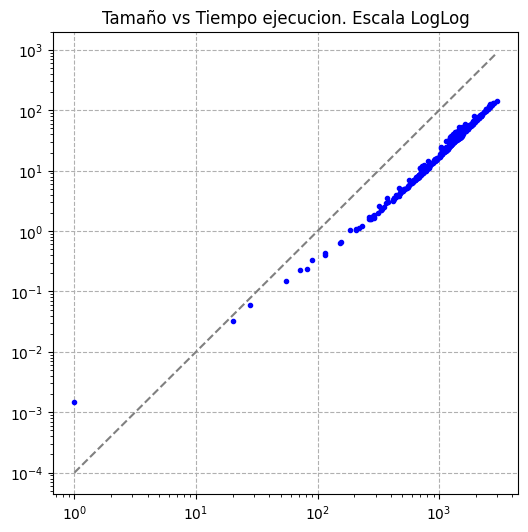

In [5]:
sizes = pd.read_csv('sizes_ben.csv', usecols=['0'])
times = pd.read_csv('times_ben.csv', usecols=['0'])
Tamaños_fases_bancos = sizes.to_numpy().reshape((len(sizes),))
Tiempos_de_ejecucion = times.to_numpy().reshape((len(times),))

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

X = np.linspace(1, 3000, num=10)

ax.loglog(Tamaños_fases_bancos, Tiempos_de_ejecucion, 'o', color='blue', markersize=3)
ax.loglog(X, (X**2)/10000, '--', color='grey')
ax.set(title='Tamaño vs Tiempo ejecucion. Escala LogLog')
ax.grid(ls='--')